In [508]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

def plot_qrc_rewards(pt_file="../data/qrc_reward_seeds.pt", name="QRC"):
    data = torch.load(pt_file)
    all_rewards = np.array(data['rewards'])  # shape: (num_seeds, num_episodes)

    # Ensure 2D shape
    if all_rewards.ndim == 1:
        all_rewards = all_rewards.reshape(1, -1)

    num_seeds, num_episodes = all_rewards.shape
    print("num_seeds :", num_seeds)
    print("num_episodes :", num_episodes)

    # Compute mean and std across seeds
    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)

    episodes = np.arange(1, num_episodes + 1)

    # 90% confidence interval
    ci_90 = 1.645 * (std_rewards / np.sqrt(num_seeds))
    plt.figure(figsize=(12,6))
    sns.lineplot(x=episodes, y=mean_rewards, label="Mean Reward", color="blue")
    plt.fill_between(episodes, mean_rewards - ci_90, mean_rewards + ci_90,
                    alpha=0.3, color="blue", label="90% CI")
    plt.title(f"{name} Training Rewards seeds 0-{num_seeds}, 90% CI")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 95% confidence interval
    ci_95 = 1.96 * (std_rewards / np.sqrt(num_seeds))
    plt.figure(figsize=(14,6))
    sns.lineplot(x=episodes, y=mean_rewards, label="Mean Reward", color="red")
    plt.fill_between(episodes, mean_rewards - ci_95, mean_rewards + ci_95,
                    alpha=0.3, color="red", label="95% CI")
    plt.title(f"{name} Training Rewards seeds 0-{num_seeds}, 95% CI")
    plt.xlabel("Episode")
    plt.ylabel("Return per Episode")
    plt.grid(True)
    plt.legend()
    plt.show()

def load_reward_file(pt_file):
    data = torch.load(pt_file)
    rewards = np.array(data['rewards'])

    if rewards.ndim == 1:
        rewards = rewards.reshape(1, -1)

    num_seeds, num_episodes = rewards.shape
    mean_rewards = rewards.mean(axis=0)
    std_rewards = rewards.std(axis=0)
    ci_95 = 1.96 * (std_rewards / np.sqrt(num_seeds))  # 95% CI

    return mean_rewards, ci_95, num_episodes, num_seeds


def plot_graph(qrc_file=None, dqn_file=None, qrc_name="QRC", dqn_name="DQN", graph_title="Training Reward Comparison"):
    plt.figure(figsize=(14, 7))

    # ---- Plot QRC ----
    if qrc_file is not None:
        qrc_mean, qrc_ci, qrc_len, qrc_seeds = load_reward_file(qrc_file)
        episodes = np.arange(1, qrc_len + 1)
        print("QRC seeds :", qrc_seeds)
        

        sns.lineplot(x=episodes, y=qrc_mean, label=qrc_name, color="red")
        # plt.fill_between(episodes, qrc_mean - qrc_ci, qrc_mean + qrc_ci, color="red",
        #                  alpha=0.25, label=f"{qrc_name} 95% CI")

    # ---- Plot DQN ----
    if dqn_file is not None:
        dqn_mean, dqn_ci, dqn_len, dqn_seeds = load_reward_file(dqn_file)
        episodes = np.arange(1, dqn_len + 1)
        print("DQN seeds :", dqn_seeds)

        sns.lineplot(x=episodes, y=dqn_mean, label=dqn_name, color="blue")
        # plt.fill_between(episodes, dqn_mean - dqn_ci, dqn_mean + dqn_ci, color="blue",
        #                  alpha=0.25, label=f"{dqn_name} 95% CI")

    plt.title(graph_title)
    plt.xlabel("Episode")
    plt.ylabel("Return per Episode")
    plt.grid(True)
    plt.legend()
    plt.show()



/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_8237/1495113101.py:53: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rewards = np.array(data['rewards'])
/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_8237/1495113101.py:53: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rewards = np.array(data['rewards'])


QRC seeds : 20
DQN seeds : 20


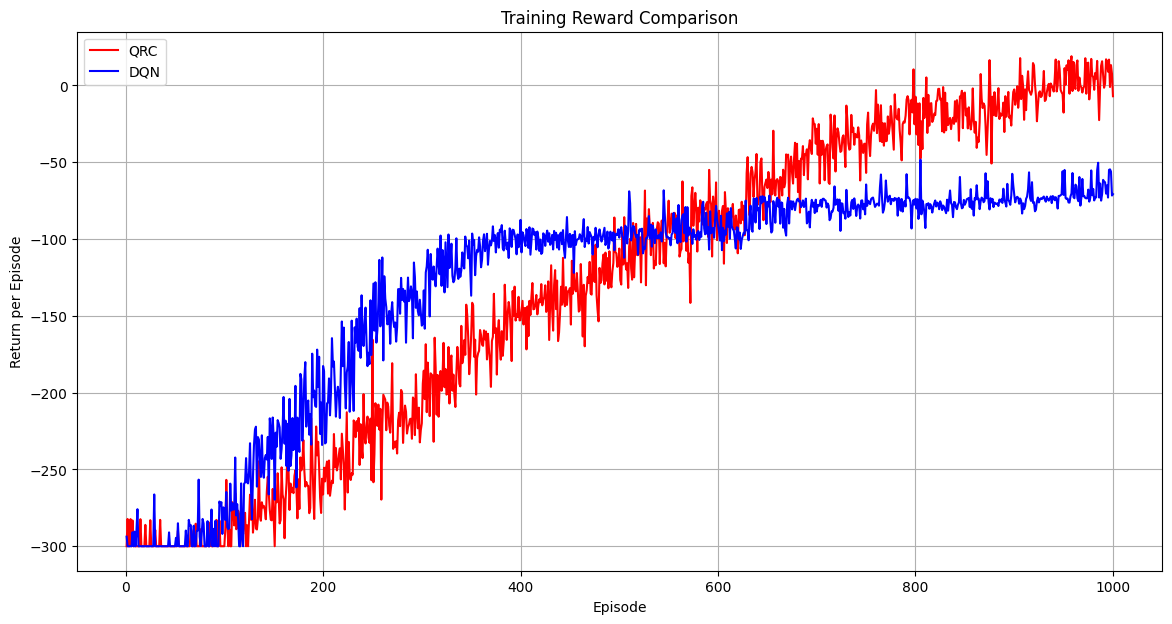

In [509]:
# plot_qrc_rewards(pt_file="../data/qrc_reward_seeds.pt", name="QRC Default")
# plot_qrc_rewards(pt_file="../data/dqn_reward_seeds.pt", name="DQN Default")

plot_graph(
    qrc_file="../data/qrc_reward_seeds_hps.pt",
    dqn_file="../data/dqn_reward_seeds_hps.pt",
)

/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_8237/1495113101.py:53: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rewards = np.array(data['rewards'])
/var/folders/w9/pv3pm_c55ts0y50r_p4hb96w0000gn/T/ipykernel_8237/1495113101.py:53: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  rewards = np.array(data['rewards'])


QRC seeds : 20
DQN seeds : 20


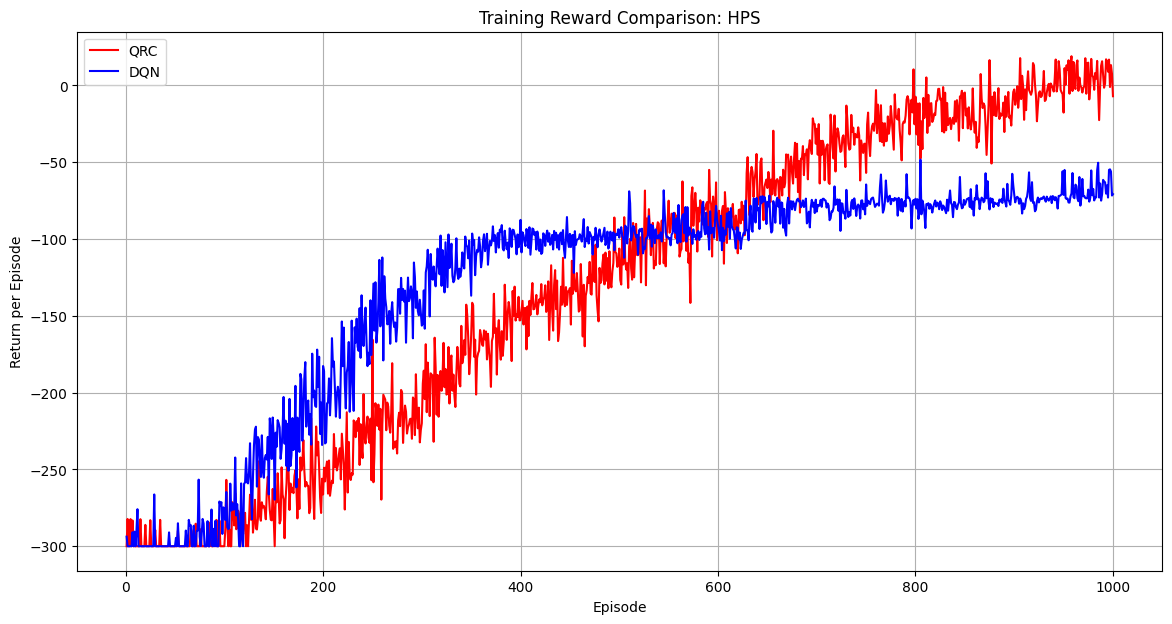

In [510]:
# plot_qrc_rewards(pt_file="../data/qrc_reward_seeds_hps.pt", name="QRC hps")
# plot_qrc_rewards(pt_file="../data/dqn_reward_seeds_target_update_2.pt", name="DQN Target Update 2")

plot_graph(
    qrc_file="../data/qrc_reward_seeds_hps.pt",
    dqn_file="../data/dqn_reward_seeds_hps.pt",
    graph_title="Training Reward Comparison: HPS"
)

In [511]:
def load_all_rewards(folder="results_qrc"):
    """Load all txt reward files from folder and return a 2D NumPy array (seeds x episodes)"""
    all_files = sorted([f for f in os.listdir(folder) if f.endswith(".txt")])
    rewards_list = []

    for index, file in enumerate(all_files):
        
        file_path = os.path.join(folder, file)
        rewards = np.loadtxt(file_path)
        # Ensure 1D array
        rewards = rewards.reshape(-1)
        rewards_list.append(rewards)

    all_rewards = np.stack(rewards_list, axis=0)  # shape: (num_seeds, num_episodes)
    return all_rewards

def plot_rewards_from_folder(folder="results_qrc", name="QRC"):
    all_rewards = load_all_rewards(folder)
    num_seeds, num_episodes = all_rewards.shape
    print(f"Loaded rewards: {num_seeds} seeds, {num_episodes} episodes each.")

    mean_rewards = np.mean(all_rewards, axis=0)
    std_rewards = np.std(all_rewards, axis=0)

    episodes = np.arange(1, num_episodes + 1)

    # 90% CI
    ci_90 = 1.645 * (std_rewards / np.sqrt(num_seeds))
    plt.figure(figsize=(12,6))
    sns.lineplot(x=episodes, y=mean_rewards, label="Mean Reward", color="blue")
    plt.fill_between(episodes, mean_rewards - ci_90, mean_rewards + ci_90,
                     alpha=0.3, color="blue", label="90% CI")
    plt.title(f"{name} Training Rewards (90% CI)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

    # 95% CI
    ci_95 = 1.96 * (std_rewards / np.sqrt(num_seeds))
    plt.figure(figsize=(12,6))
    sns.lineplot(x=episodes, y=mean_rewards, label="Mean Reward", color="red")
    plt.fill_between(episodes, mean_rewards - ci_95, mean_rewards + ci_95,
                     alpha=0.3, color="red", label="95% CI")
    plt.title(f"{name} Training Rewards (95% CI) : Seed {num_seeds}")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.show()

def plot_multiple_rewards(folders, names, ci=0.95):
    """
    Plot mean rewards with CI for multiple folders on the same graph.
    
    folders : list of folder paths
    names   : list of names corresponding to folders
    ci      : confidence interval (0.9 or 0.95)
    """
    assert len(folders) == len(names), "folders and names must have same length"

    plt.figure(figsize=(14,7))

    for folder, name in zip(folders, names):
        all_rewards = load_all_rewards(folder)
        num_seeds, num_episodes = all_rewards.shape

        mean_rewards = np.mean(all_rewards, axis=0)
        std_rewards = np.std(all_rewards, axis=0)
        episodes = np.arange(1, num_episodes + 1)

        if ci == 0.90:
            ci_multiplier = 1.645
        elif ci == 0.95:
            ci_multiplier = 1.96
        else:
            raise ValueError("CI must be 0.90 or 0.95")

        ci_values = ci_multiplier * (std_rewards / np.sqrt(num_seeds))

        sns.lineplot(x=episodes, y=mean_rewards, label=name)
        plt.fill_between(episodes, mean_rewards - ci_values, mean_rewards + ci_values,
                         alpha=0.3)

        print(f"[{name}] Seeds: {num_seeds}, Episodes: {num_episodes}")

    plt.title(f"Training Rewards Comparison ({int(ci*100)}% CI)")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.grid(True)
    plt.legend()
    plt.show()
    

[Mac QRC] Seeds: 250, Episodes: 1000
[CC QRC] Seeds: 210, Episodes: 1000
[HPS QRC h] Seeds: 251, Episodes: 1000


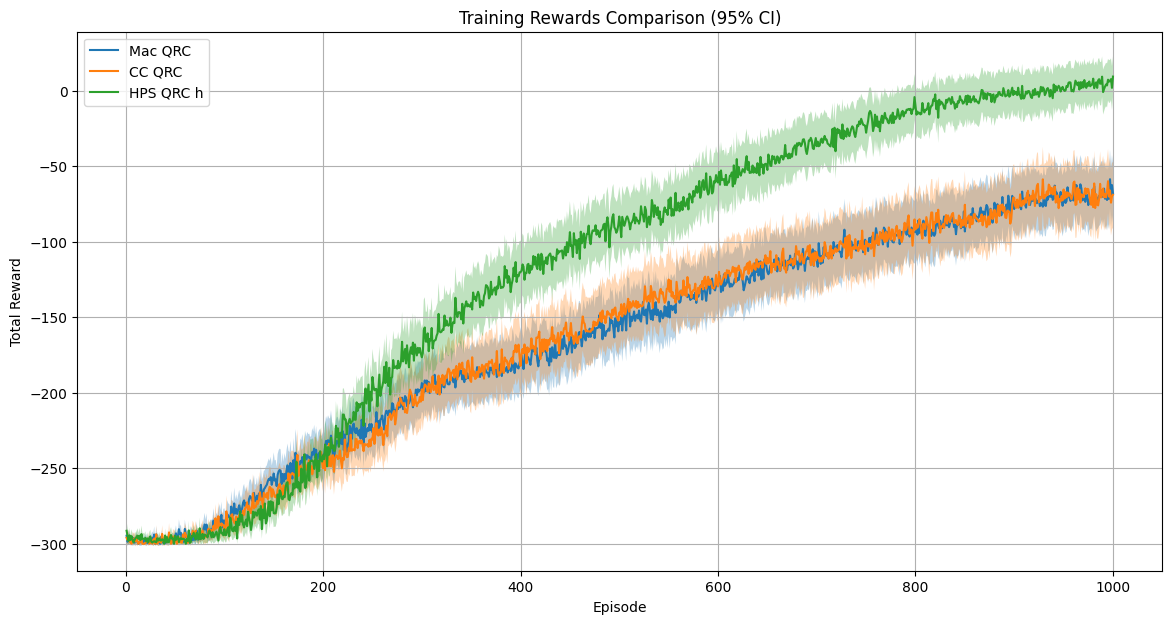

In [512]:
folders = ["../data/qrc_parallel_run/results_qrc", "../data/qrc_parallel_run/results", "../data/qrc_parallel_run/results_hps"]
names = ["Mac QRC", "CC QRC", "HPS QRC h"]
plot_multiple_rewards(folders, names, ci=0.95)